Weather Forecasting with 4 features using historical data via TDNN recursive forecasting

Model ver. 18 March 2024.

In [ ]:
# Required Import Statements
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


In [ ]:
# Define the TDNN Model
class TDNN(nn.Module):
    def __init__(self, window_size1=10):
        super(TDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * window_size1, 4)  # Adjust based on the output of conv layers

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Convert time series data to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Function to Create Sequences
def create_sequences(data, window_size=10):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size]) # 1..10, 2..11, 3..12, ......
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

# Evaluation Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    predictions = predictions.numpy()
    y_test = y_test.numpy()

    mae = mean_absolute_error(y_test, predictions)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    return mae, rmse

**Section 1:**

Data initiation and transformation

In [ ]:
# Link to 6 weather datasets
url_ottawa = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv"
url_ottawa_south = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawasouth_daily.csv"
url_gatineau = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_gatineau_daily.csv"
url_chelsea = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_chelsea_daily.csv"
url_kemptville = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_kemptville_daily.csv"
url_renfrew = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_renfrew_daily.csv"

# Load and Preprocess Data
url = url_ottawa_south
#url = 'https://raw.githubusercontent.com/Sattar-A/HonoursProject_CSI4900/main/data/weatherstats_ottawa_daily.csv?token=GHSAT0AAAAAACNBWJ7MI3IZIOPLGQ6OLTU4ZPPCOYA'
data = pd.read_csv(url)

# data processing transformation
data['date'] = pd.to_datetime(data['date'])
filtered_data = data[(data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]  # restrict data range from May to November
filtered_data = filtered_data[(filtered_data['date'].dt.year >= 2013) & (filtered_data['date'].dt.year <= 2023)]  # overall data range from years 2013-2023
selected_columns = ['avg_hourly_temperature', 'precipitation', 'solar_radiation', 'avg_hourly_pressure_station']  # set 4 features for input and output
final_data = filtered_data[selected_columns]
# test data processing
#test_data = final_data[(filtered_data['date'].dt.year == 2023)] # data from 2023 only

#window size
window_size = 14
pred_size = 1

# Handle Missing Values
#final_data = final_data.fillna(method='ffill')  # option 1: forward fill
final_data = final_data.dropna()  # option 2: drop data with null values

# Normalize the Data
scaler = MinMaxScaler()  # MinMax scaler
scaled_data = scaler.fit_transform(final_data)

final_data.head(7)

<ipython-input-13-dd762e631a1a>:12: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


,avg_hourly_temperature,precipitation,solar_radiation,avg_hourly_pressure_station
62,2.74,0.0,4460.0,99.59
63,-3.26,0.2,4626.0,99.75
64,-5.13,0.0,6134.0,99.37
65,1.95,0.0,3812.0,98.81
66,0.98,0.5,5107.0,100.13
67,-2.95,0.0,7346.0,101.07
68,-6.37,0.0,9044.0,100.90


In [ ]:
# Assuming `scaled_data` is your normalized dataset
prepared_data = series_to_supervised(scaled_data, n_in=window_size, n_out=pred_size)

# Split into input and output parts
X = prepared_data.iloc[:, :-(4*1)].values  # 4 features, last columns are the output
y = prepared_data.iloc[:, -4:].values  # last 4 columns as the output

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


In [ ]:
# Function to Create Sequences for model training
X, y = create_sequences(scaled_data, window_size)

# Splitting the Data and reshaping to 'parallelogram stack'
dates = filtered_data['date'].values
index_2023 = np.where(dates >= np.datetime64('2023-01-01'))[0][0] - window_size

X_train, X_test = X[:index_2023], X[index_2023:]
y_train, y_test = y[:index_2023], y[index_2023:]

# Creating the training and testing sets with sequences
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



In [ ]:
# Training option #1: direct single-step
model = TDNN(window_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.25701630115509033
Epoch 10, Loss: 0.06633635610342026
Epoch 20, Loss: 0.04563860222697258
Epoch 30, Loss: 0.036484453827142715
Epoch 40, Loss: 0.03251597657799721


In [ ]:
# Training option #2: recursive forecast (step size 10)

# Initialize an empty array for storing recursive forecasts
recursive_forecasts = np.zeros((X_test.shape[0], X_test.shape[2]))  # Shape: (number of test days, number of features)

# Starting window for recursive forecasting
current_window = X_test[0].unsqueeze(0)  # Assuming X_test is a PyTorch tensor

for i in range(X_test.shape[0]):
    # Make a prediction with the current window
    with torch.no_grad():  # Ensure no gradients are computed
        current_pred = model(current_window).detach().numpy()

    # Store the prediction
    recursive_forecasts[i] = current_pred

    # Prepare the next window
    if i + 1 < X_test.shape[0]:  # Check to avoid index error on the last prediction
        next_window = X_test[i + 1].numpy()
        # Update the window with the new prediction (recursive step)
        # Remove the oldest day (first row) and append the new prediction at the end
        next_window[:-1] = next_window[1:]
        next_window[-1] = current_pred

        # Convert back to PyTorch tensor for the next iteration
        current_window = torch.tensor(next_window).unsqueeze(0).float()

# Optional: Scale back the predictions to their original range if you normalized your data
recursive_forecasts_scaled = scaler.inverse_transform(recursive_forecasts)

# Now `recursive_forecasts_scaled` contains the recursively predicted values for each day in the test dataset


In [ ]:
# Evaluate the Model
mae, rmse = evaluate_model(model, X_test, y_test)
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 0.09280500560998917, RMSE: 0.12380902461927633


In [ ]:
# evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'y_test_actual' contains the actual values for the test data, scaled to the original range
# You may need to extract these actual values from your dataset similarly to how you prepared your test data

# Ensure the shapes of `recursive_forecasts_scaled` and `y_test_actual` are compatible


# If `y_test_actual` is a PyTorch tensor, convert it to a numpy array and possibly scale back if it was normalized
y_test_actual = y_test.numpy()  # Assuming it's a tensor and needs conversion
#y_test_actual = test_data.numpy()
y_test_actual_scaled = scaler.inverse_transform(y_test)  # Uncomment if scaling is needed

# Calculate MAE and RMSE for each feature across the test dataset
mae = mean_absolute_error(y_test_actual, recursive_forecasts_scaled)
rmse = np.sqrt(mean_squared_error(y_test_actual, recursive_forecasts_scaled))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Square Error (RMSE): {rmse}')


ValueError: Found input variables with inconsistent numbers of samples: [14, 7]

Testing

In [ ]:
# Assuming `filtered_data` includes the 'date' column and corresponds to the original dataset
test_data = filtered_data[filtered_data['date'].dt.year == 2023]

# Normalize predictions and actual values back to their original scale
predictions = model(X_test).detach().numpy()
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.numpy())

# Names of the features for reference
feature_names = ['Precipitation', 'Avg Hourly Temperature', 'Solar Radiation', 'Avg Hourly Pressure Station']

for i, feature_name in enumerate(feature_names):
    mae = mean_absolute_error(y_test_scaled[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_scaled[:, i], predictions[:, i]))
    print(f'{feature_name} - Mean Absolute Error: {mae}')
    print(f'{feature_name} - Root Mean Square Error: {rmse}\n')

# Sample comparison for each feature
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

for i, feature_name in enumerate(feature_names):
    comparison_with_dates = pd.DataFrame({
        'Date': test_dates,
        f'Actual {feature_name}': y_test_scaled[:, i],
        f'Predicted {feature_name}': predictions[:, i]
    })

    print(f"Comparison for {feature_name} (First 5 Rows):")
    print(comparison_with_dates.head(5), '\n')


Precipitation - Mean Absolute Error: 3.646491527557373
Precipitation - Root Mean Square Error: 4.263980388641357

Avg Hourly Temperature - Mean Absolute Error: 4.592803478240967
Avg Hourly Temperature - Root Mean Square Error: 8.012035369873047

Solar Radiation - Mean Absolute Error: 4885.84375
Solar Radiation - Root Mean Square Error: 5834.67041015625

Avg Hourly Pressure Station - Mean Absolute Error: 0.40130123496055603
Avg Hourly Pressure Station - Root Mean Square Error: 0.48279741406440735

Comparison for Precipitation (First 5 Rows):
        Date  Actual Precipitation  Predicted Precipitation
0 2023-11-30             19.729998                14.697276
1 2023-11-29             20.029999                14.927372
2 2023-11-28             21.520000                14.807180
3 2023-11-27             21.080000                15.222472
4 2023-11-26             20.180000                16.664122 

Comparison for Avg Hourly Temperature (First 5 Rows):
        Date  Actual Avg Hourly Tempe

Model prediction visualization

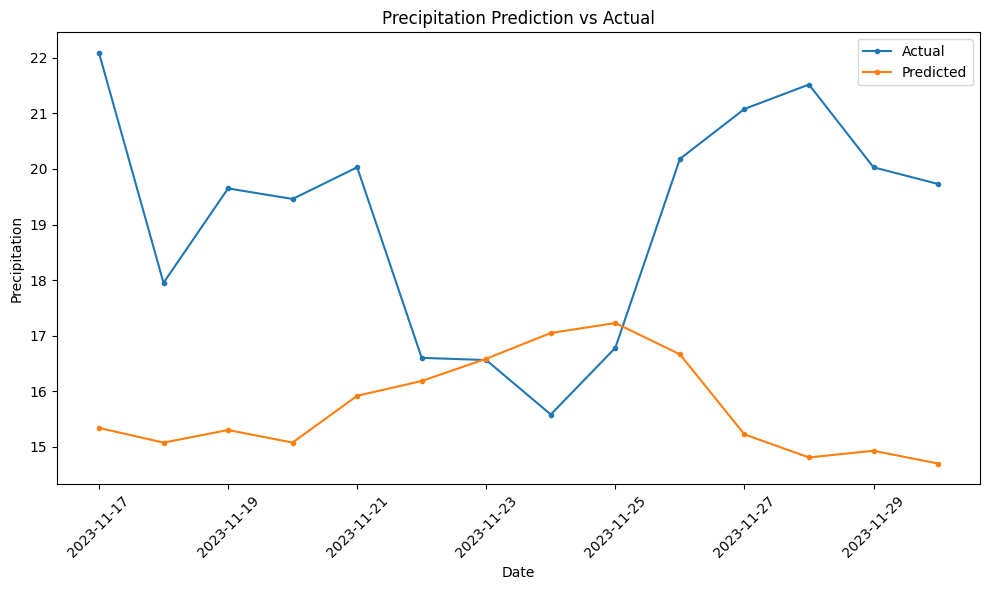

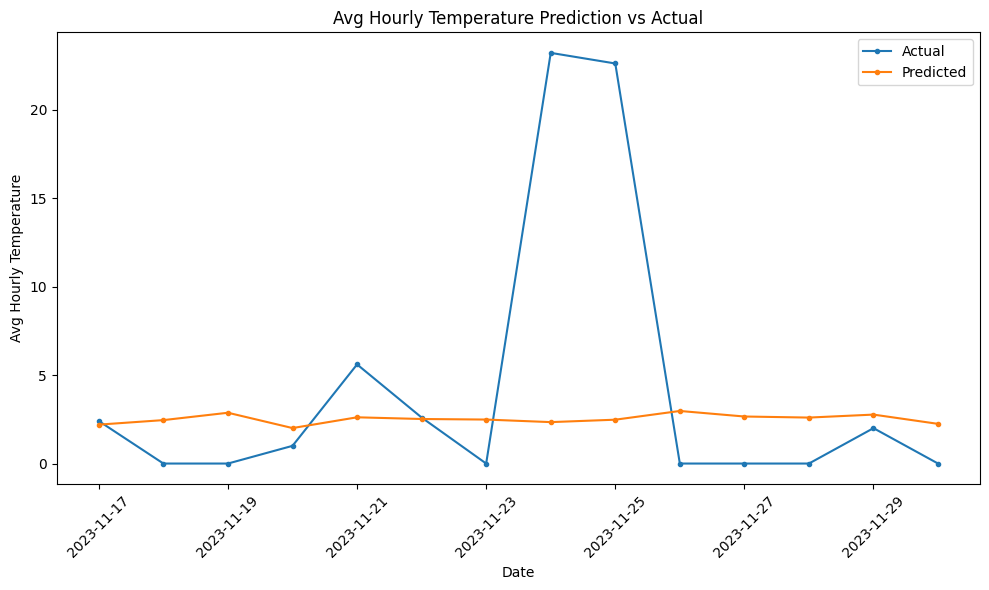

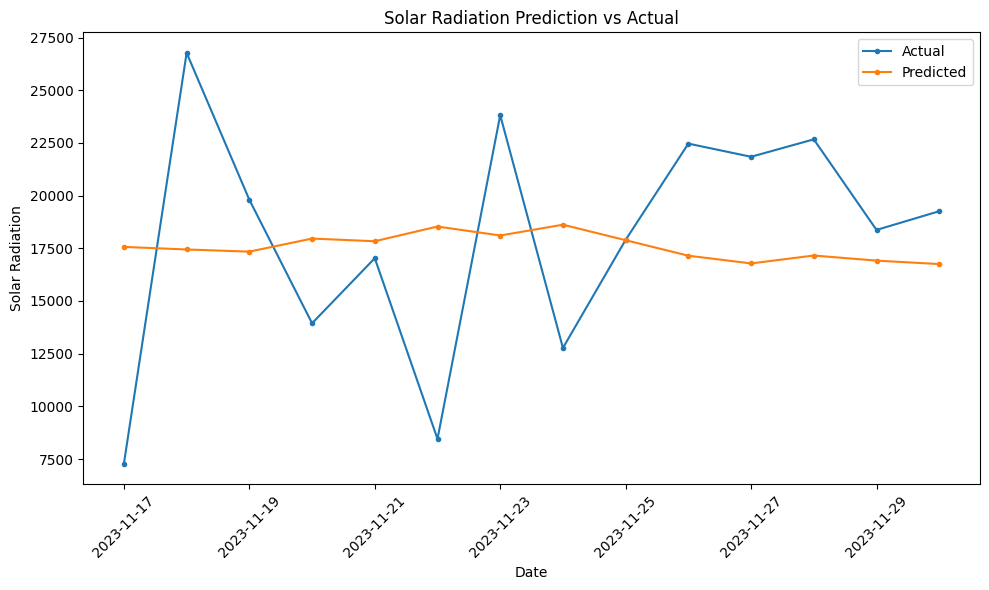

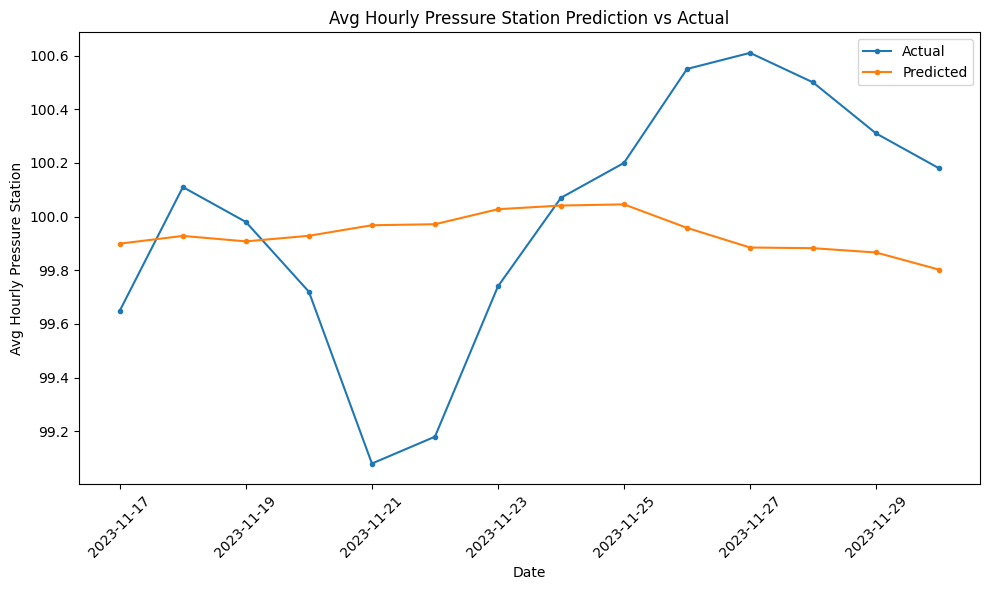

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test_scaled' are your model's predictions and actual values, respectively, scaled back to their original range

feature_names = ['Precipitation', 'Avg Hourly Temperature', 'Solar Radiation', 'Avg Hourly Pressure Station']
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

for i, feature_name in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, y_test_scaled[:, i], label='Actual', marker='.', zorder=-1)
    plt.plot(test_dates, predictions[:, i], label='Predicted', marker='.', zorder=1)
    plt.title(f'{feature_name} Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
